In [8]:
# Load the Drive helper and mount
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
processed=pd.read_csv('drive/My Drive/HeartDeases_dataset/processed.cleveland.data.csv')
reprocessed=pd.read_csv('drive/My Drive/HeartDeases_dataset/reprocessed_hungarian_data.csv')

In [11]:
processed.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
298,45,1,1,110,264,0,0,132,0,1.2,2,0,7,1
299,68,1,4,144,193,1,0,141,0,3.4,2,2,7,2
300,57,1,4,130,131,0,0,115,1,1.2,2,1,7,3
301,57,0,2,130,236,0,2,174,0,0.0,2,1,3,1
302,38,1,3,138,175,0,0,173,0,0.0,1,?,3,0


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
298,45,1,1,110,264,0,0,132,0,1.2,2,0,7,1
299,68,1,4,144,193,1,0,141,0,3.4,2,2,7,2
300,57,1,4,130,131,0,0,115,1,1.2,2,1,7,3
301,57,0,2,130,236,0,2,174,0,0.0,2,1,3,1
302,38,1,3,138,175,0,0,173,0,0.0,1,?,3,0


In [12]:
processed.target.unique()

array([0, 2, 1, 3, 4])

array([0, 2, 1, 3, 4])

In [13]:
reprocessed=reprocessed.iloc[:,:-1]
reprocessed.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
289,48,0,2,-9,308,0,1,-9,-9,2.0,1,-9,-9,0
290,36,1,2,120,166,0,0,180,0,0.0,-9,-9,-9,0
291,48,1,3,110,211,0,0,138,0,0.0,-9,-9,6,0
292,47,0,2,140,257,0,0,135,0,1.0,1,-9,-9,0
293,53,1,4,130,182,0,0,148,0,0.0,-9,-9,-9,0


In [14]:
reprocessed.target.unique()

array([0, 1, 3, 4, 2])

In [15]:
data=pd.concat([processed,reprocessed])
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


# Handling Missing Values

In [0]:
# mark all missing values
data.replace('?', np.nan, inplace=True)
# make dataset numeric
data = data.astype('float32')

In [0]:
columns=data.columns
X=data.values

from sklearn.impute import SimpleImputer 
imputer = SimpleImputer(missing_values=np.nan,strategy='most_frequent')
X[:,:-1]=imputer.fit_transform(X[:,:-1])

imputer2 =SimpleImputer(missing_values=np.nan,strategy='most_frequent')
X[:,-1:]=imputer2.fit_transform(X[:,-1:])

In [18]:
data=pd.DataFrame(data=X,columns=columns)
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0.0


#Data Perprocessing

#Selecting important features based on correlation

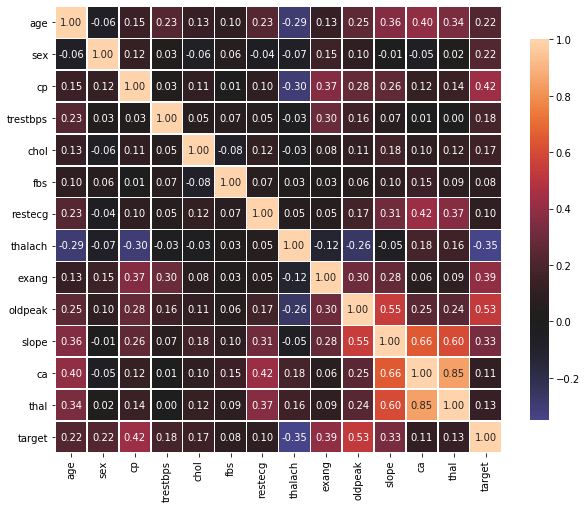

In [19]:
def correlation_heatmap(data):
    correlations = data.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();
correlation_heatmap(data)


In [0]:
corr = data.corr()

In [0]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = data.columns[columns]
data = data[selected_columns]

In [22]:
data.shape

(597, 14)

In [0]:
import statsmodels.regression.linear_model as sm
selected_columns = selected_columns[:-1].values
def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns
SL = 0.05
data_modeled, selected_columns = backwardElimination(data.iloc[:,:-1].values, data.iloc[:,-1].values, SL, selected_columns)

In [0]:
final_data=pd.DataFrame(data=data_modeled,columns=selected_columns)

In [25]:
final_data.head()

,sex,cp,trestbps,chol,thalach,exang,oldpeak
0,1.0,1.0,145.0,233.0,150.0,0.0,2.3
1,1.0,4.0,160.0,286.0,108.0,1.0,1.5
2,1.0,4.0,120.0,229.0,129.0,1.0,2.6
3,1.0,3.0,130.0,250.0,187.0,0.0,3.5
4,0.0,2.0,130.0,204.0,172.0,0.0,1.4


In [0]:
final_data['target']=data.iloc[:,-1]

In [27]:
final_data.head()

,sex,cp,trestbps,chol,thalach,exang,oldpeak,target
0,1.0,1.0,145.0,233.0,150.0,0.0,2.3,0.0
1,1.0,4.0,160.0,286.0,108.0,1.0,1.5,2.0
2,1.0,4.0,120.0,229.0,129.0,1.0,2.6,1.0
3,1.0,3.0,130.0,250.0,187.0,0.0,3.5,0.0
4,0.0,2.0,130.0,204.0,172.0,0.0,1.4,0.0


In [0]:
for i in range(0,len(final_data)):
  if final_data.iloc[i,-1]>=1:
    final_data.iloc[i,-1]=1
  else:
    final_data.iloc[i,-1]=0

In [29]:
final_data.head()

,sex,cp,trestbps,chol,thalach,exang,oldpeak,target
0,1.0,1.0,145.0,233.0,150.0,0.0,2.3,0.0
1,1.0,4.0,160.0,286.0,108.0,1.0,1.5,1.0
2,1.0,4.0,120.0,229.0,129.0,1.0,2.6,1.0
3,1.0,3.0,130.0,250.0,187.0,0.0,3.5,0.0
4,0.0,2.0,130.0,204.0,172.0,0.0,1.4,0.0


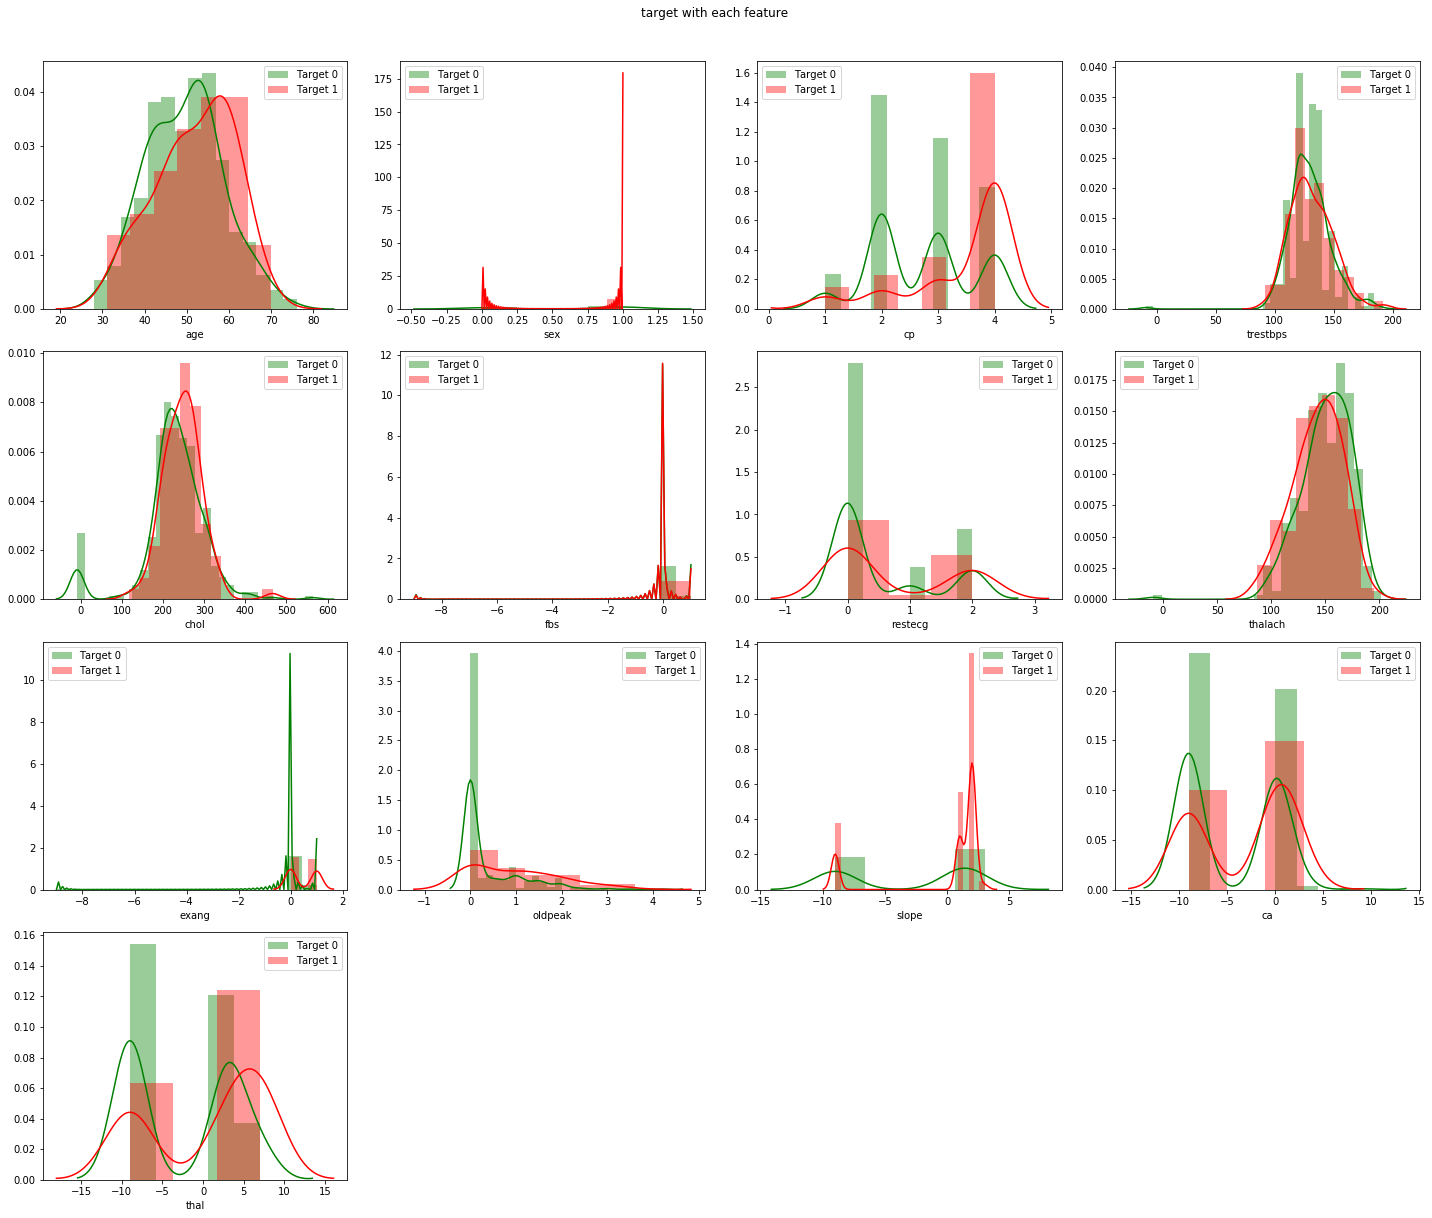

In [30]:
fig = plt.figure(figsize = (20, 25))
j = 0
for i in data.columns:
    if(i=='target'):
      break;
    plt.subplot(6, 4, j+1)
    j += 1
    sns.distplot(data[i][data['target']==0], color='g', label = 'Target 0')
    sns.distplot(data[i][data['target']==1], color='r', label = 'Target 1')
    plt.legend(loc='best')
fig.suptitle('target with each feature ')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [0]:
classes_count=final_data.target.value_counts()

Text(0.5, 1.0, 'Records in each class')

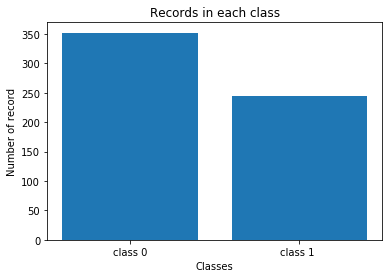

In [32]:
x=[1,2]
plt.bar(x,classes_count)
plt.xticks(x,['class 0','class 1 '])
plt.xlabel('Classes')
plt.ylabel('Number of record')
plt.title('Records in each class')

In [0]:

X=final_data.iloc[:,:-1].values
y=final_data.iloc[:,-1].values

#Data Augmentation

In [34]:
from collections import Counter
print("Before OverSampling, counts of label ': {}".format(Counter(y))) 
  

from imblearn.over_sampling import SVMSMOTE 
sm = SVMSMOTE(random_state = 2,sampling_strategy='auto',) 
X_res, y_res = sm.fit_sample(X, y.ravel()) 
  
print('After OverSampling, the shape of train_X: {}'.format(X_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_res.shape)) 
  

print("After OverSampling, counts of label ': {}".format(Counter(y_res))) 


Before OverSampling, counts of label ': Counter({0.0: 352, 1.0: 245})
After OverSampling, the shape of train_X: (704, 7)
After OverSampling, the shape of train_y: (704,) 

After OverSampling, counts of label ': Counter({0.0: 352, 1.0: 352})


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

In [35]:
print(X_res.shape)
print(y_res.shape)

(704, 7)
(704,)


In [0]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X_res,y_res,test_size=0.15,shuffle=True,random_state=123)

#Data Scalling

In [0]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [38]:
from keras import Sequential
from keras.layers import Dense,Dropout
from keras.optimizers import Adam


Using TensorFlow backend.


#Deep Neural Network

In [39]:

model=Sequential()
model.add(Dense(128, init="uniform", input_dim=7, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, init ="uniform",activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(32, init ="uniform",activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(16, init ="uniform"))
model.add(Dropout(0.1))
model.add(Dense(1, init="uniform", activation="sigmoid"))







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, input_dim=7, activation="relu", kernel_initializer="uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, activation="relu", kernel_initializer="uniform")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, kernel_initializer="uniform")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation

In [40]:
adam = Adam(lr=0.01)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
________________________

In [41]:
history =model.fit(x_train, y_train, batch_size = 200, nb_epoch = 200)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.





Epoch 1/200





598/598 [==============================] - 1s 1ms/step - loss: 0.6930 - acc: 0.4816
Epoch 2/200
598/598 [==============================] - 0s 28us/step - loss: 0.6803 - acc: 0.7993
Epoch 3/200
598/598 [==============================] - 0s 35us/step - loss: 0.5697 - acc: 0.8077
Epoch 4/200
598/598 [==============================] - 0s 28us/step - loss: 0.4974 - acc: 0.8127
Epoch 5/200
598/598 [==============================] - 0s 26us/step - loss: 0.4726 - acc: 0.8094
Epoch 6/200
598/598 [==============================] - 0s 28us/step - loss: 0.4400 - acc: 0.8144
Epoch 7/200
598/598 [==============================] - 0s 27us/step - loss: 0.4443 - acc: 0.8144
Epoch 8/200
598/598 [==============================] - 0s 28us/step - loss: 0.4402 - acc: 0.8127
Epoch 9/200
598/598 [==============================] - 0s 32us/step - loss: 0.4410 - acc: 0.8161
Epoch 10/200
598/598 [==============================] - 0s 30us/step - loss: 0.4147 - acc: 0.8211
Epoch 11/200
598/598 [

Text(0.5, 0, 'epochs')

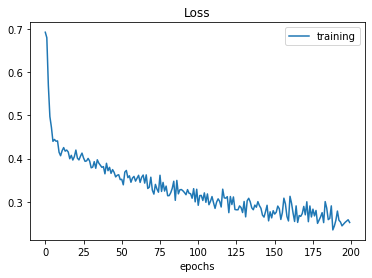

In [42]:
plt.plot(history.history['loss'])
plt.legend(['training'])
plt.title('Loss')
plt.xlabel('epochs')

In [0]:
from keras.models import load_model
model1 = load_model('drive/My Drive/model_fi.h5')

In [44]:
accr = model1.evaluate(x_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.1f} %'.format(accr[0],round(accr[1]*100,1)))

106/106 [==============================] - 0s 968us/step
Test set
  Loss: 0.135
  Accuracy: 92.5 %
